In [1]:
%matplotlib inline

# Deep Learning with PyTorch Image Classifier Tutorial

This tutorial is adapted from [the PyTorch Tutorials](https://pytorch.org/tutorials/), valuable references for learning the fundamentals of Deep Learning with PyTorch. We highly recommend exploring other tutorials for a deeper understanding and additional topics.

In this tutorial, we'll be working with the CIFAR10 dataset, which includes classes such as 'airplane,' 'automobile,' 'bird,' 'cat,' 'deer,' 'dog,' 'frog,' 'horse,' 'ship,' and 'truck.' The images in CIFAR-10 have dimensions of 3x32x32, indicating they are 3-channel color images with a resolution of 32x32 pixels.

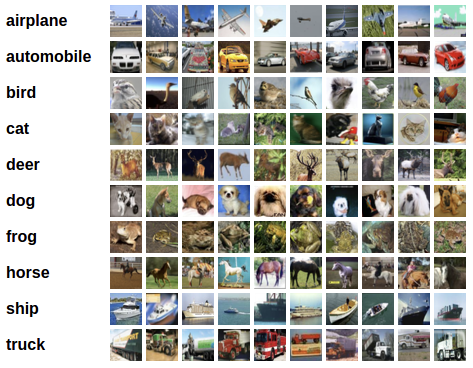

   cifar10

In [2]:
# Importing necessary modules
import sys  # Module for interacting with the Python interpreter
import os   # Module for interacting with the operating system

# Checking if the code is running in Google Colab
if 'google.colab' in sys.modules:
    print(f"Running in Google Colab ...")

    # Setting the data directory path for Google Colab environment
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = os.path.join('/content/drive', 'My Drive')
else:
    # Code is running in a local setup
    print(f"Running in Local Setup ...")

    # Setting the data directory path for local environment
    root_dir = os.path.join('.')

data_dir = os.path.join(root_dir, 'data')

# Displaying the selected root and data directories
print(f"Using Root Directory: {root_dir}")
print(f"Using Data Directory: {data_dir}")

Running in Google Colab ...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using Root Directory: /content/drive/My Drive
Using Data Directory: /content/drive/My Drive/data


## Image Classifier Training Process

The sequential steps for training an image classifier are as follows:

1. Utilize the `torchvision` library to load and normalize both the training and test datasets of CIFAR10.
2. Establish a Convolutional Neural Network (CNN).
3. Specify a loss function for the model.
4. Initiate the training of the network using the training data.
5. Evaluate the trained network's performance on the test data.

### 1. Loading and Normalizing CIFAR10

CIFAR10 can be effortlessly loaded using the `torchvision` library.

In [3]:
# Import the PyTorch library
import torch

# Import the torchvision library, which provides datasets, models, and
# transformations for computer vision tasks
import torchvision

# Import the transforms module from torchvision to apply image transformations
import torchvision.transforms as transforms

In [4]:
# Determine the optimal device for computations, prioritizing GPUs and MPS:
device = torch.device(
    "cuda"  # Prioritize GPU if available
    if torch.cuda.is_available()
    else "mps"  # use MPS if available
    if torch.backends.mps.is_available()
    else "cpu"  # Fallback to CPU
)

# Print the selected device for clarity:
print(f"Torch Device: {device}")

Torch Device: cuda


The torchvision datasets yield PILImage images with a pixel value range of [0, 1]. To convert them into Tensors, we apply a transformation that normalizes the values to the range of [-1, 1].

<div class="alert alert-info"><h4>Note</h4><p>If encountering a BrokenPipeError on Windows, consider resolving the issue by adjusting the `num_worker` parameter of `torch.utils.data.DataLoader()` to 0.</p></div>



In [5]:
# Define a sequence of image transformations using transforms.Compose
transform = transforms.Compose(
    [
        # Convert the PILImage to a PyTorch Tensor
        transforms.ToTensor(),

        # Normalize the Tensor with mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [6]:
# Set the batch size for loading data
batch_size = 4

# Create a training dataset instance using CIFAR10, specifying the root directory,
# enabling training mode, and applying the defined transformation
trainset = torchvision.datasets.CIFAR10(root=data_dir,
                                        train=True,
                                        download=True,
                                        transform=transform)

# Create a DataLoader for training, specifying the dataset, batch size,
# enabling shuffling, and the number of worker processes
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

# Create a testing dataset instance using CIFAR10, specifying the root directory,
# disabling training mode, and applying the defined transformation
testset = torchvision.datasets.CIFAR10(root=data_dir,
                                       train=False,
                                       download=True,
                                       transform=transform)

# Create a DataLoader for testing, specifying the dataset, batch size,
# disabling shuffling, and the number of worker processes
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Define a tuple 'classes' representing the labels/categories for CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's display a selection of training images.



In [8]:
# Import the pyplot module from the matplotlib library for plotting
import matplotlib.pyplot as plt

# Import the numpy library, commonly aliased as np, for numerical operations
# and array handling
import numpy as np

In [9]:
# Define a function 'imshow' to display an image
def imshow(img):
    # Unnormalize the image by scaling it back to the original range [0, 1]
    img = img / 2 + 0.5

    # Convert the PyTorch tensor to a NumPy array
    npimg = img.numpy()

    # Transpose the array to switch channels to the last dimension
    # (from CxHxW to HxWxC)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Display the image
    plt.show()

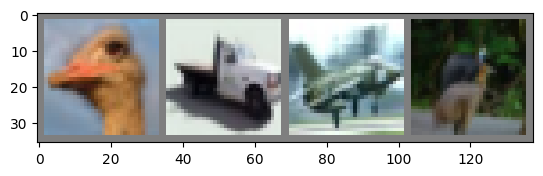

bird  truck plane bird 


In [10]:
# Obtain a batch of random training images using the iterator 'dataiter'
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display the batch of images using the 'imshow' function and 'make_grid'
# utility from torchvision
imshow(torchvision.utils.make_grid(images))

# Print the corresponding labels for the displayed images
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Design a Convolutional Neural Network

Replicate the neural network architecture from the [Neural Networks Tutorial](https://github.com/darinz/DL-PT-NN) and adapt it to accommodate 3-channel images, in contrast to the initial definition for 1-channel images.

In [11]:
# Import the neural network module (nn) and functional module (F) from the
# PyTorch library
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# Define a neural network class 'Net' that inherits from the nn.Module class
class Net(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class
        super().__init__()

        # Define the layers of the neural network
        # Convolutional layer with input channels=3, output channels=6, kernel size=5
        self.conv1 = nn.Conv2d(3, 6, 5)

        # Max pooling layer with kernel size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutional layer with input channels=6, output channels=16, kernel size=5
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Fully connected layer with input size=16*5*5 and output size=120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # Fully connected layer with input size=120 and output size=84
        self.fc2 = nn.Linear(120, 84)

        # Fully connected layer with input size=84 and output size=10 (number of classes)
        self.fc3 = nn.Linear(84, 10)

    # Define the forward pass of the neural network
    def forward(self, x):
        # Apply convolution 1, relu activation, and pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply convolution 2, relu activation, and pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the tensor along all dimensions except batch
        x = torch.flatten(x, 1)

        # Apply activation to the first fully connected layer
        x = F.relu(self.fc1(x))

        # Apply activation to the second fully connected layer
        x = F.relu(self.fc2(x))

        # Output layer without activation (logits)
        x = self.fc3(x)

        return x

In [13]:
# Instantiate an object 'net' of the neural network class 'Net' and
# move it to the specified device (e.g., GPU)
net = Net().to(device)

### 3. Define a Loss Function and Optimizer

We will employ a Classification Cross-Entropy loss and utilize Stochastic Gradient Descent (SGD) with momentum for optimization.


In [14]:
# Import the optimization module from PyTorch, commonly aliased as optim
import torch.optim as optim

In [15]:
# Define the Cross-Entropy loss criterion for classification tasks
criterion = nn.CrossEntropyLoss()

# Instantiate the Stochastic Gradient Descent (SGD) optimizer,
# specifying the parameters to be optimized, learning rate (lr), and momentum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Training the Network

This is where the real action begins. All we need to do is iterate over our data set, provide the inputs to the network, and optimize the model.

In [16]:
# Iterate over the dataset for a specified number of EPOCHS (here, 2 epochs)
EPOCHS = 10
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    # Initialize the running loss to track training progress
    running_loss = 0.0

    # Iterate over mini-batches within the training DataLoader
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate the loss for printing statistics
        running_loss += loss.item()

        # print statistics every 2000 mini-batches
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

            # reset running loss for the next set of mini-batches
            running_loss = 0.0

# Print a message indicating the completion of training
print('Finished Training')

[1,  2000] loss: 2.205
[1,  4000] loss: 1.855
[1,  6000] loss: 1.679
[1,  8000] loss: 1.607
[1, 10000] loss: 1.535
[1, 12000] loss: 1.484
[2,  2000] loss: 1.434
[2,  4000] loss: 1.387
[2,  6000] loss: 1.362
[2,  8000] loss: 1.333
[2, 10000] loss: 1.314
[2, 12000] loss: 1.299
[3,  2000] loss: 1.234
[3,  4000] loss: 1.219
[3,  6000] loss: 1.225
[3,  8000] loss: 1.216
[3, 10000] loss: 1.197
[3, 12000] loss: 1.180
[4,  2000] loss: 1.116
[4,  4000] loss: 1.120
[4,  6000] loss: 1.129
[4,  8000] loss: 1.120
[4, 10000] loss: 1.119
[4, 12000] loss: 1.111
[5,  2000] loss: 1.041
[5,  4000] loss: 1.065
[5,  6000] loss: 1.033
[5,  8000] loss: 1.053
[5, 10000] loss: 1.062
[5, 12000] loss: 1.057
[6,  2000] loss: 0.956
[6,  4000] loss: 1.005
[6,  6000] loss: 1.003
[6,  8000] loss: 1.020
[6, 10000] loss: 1.010
[6, 12000] loss: 1.009
[7,  2000] loss: 0.928
[7,  4000] loss: 0.940
[7,  6000] loss: 0.950
[7,  8000] loss: 0.967
[7, 10000] loss: 0.955
[7, 12000] loss: 0.978
[8,  2000] loss: 0.869
[8,  4000] 

Let's save our trained model:

In [17]:
# Define the file path for saving the trained model
PATH = os.path.join(root_dir, 'cifar_net.pth')

# Save the state dictionary of the neural network to the specified file path
torch.save(net.state_dict(), PATH)

Refer to the [PyTorch Documentation](https://pytorch.org/docs/stable/notes/serialization.html) for additional details on saving PyTorch models.

### 5. Testing the Network on the Test Data

After training the network for 2 passes over the training dataset, it's crucial to assess whether the network has learned effectively. To do this, we'll predict the class label output by the neural network and compare it against the ground-truth. If the prediction is correct, we'll add the sample to the list of correct predictions.

Let's start by displaying an image from the test set to get acquainted.

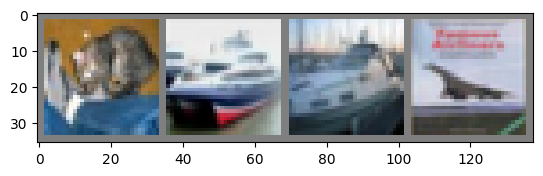

GroundTruth:  cat   ship  ship  plane


In [18]:
# Obtain a batch of images from the test DataLoader using the iterator 'dataiter'
dataiter = iter(testloader)
images, labels = next(dataiter)

# Display the batch of images using the 'imshow' function and 'make_grid' utility from torchvision
imshow(torchvision.utils.make_grid(images))

# Print the ground truth labels corresponding to the displayed images
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, we'll reload our saved model. Note that saving and reloading the model wasn't necessary here; we did it to illustrate the process.

In [19]:
# Instantiate a new instance of the neural network class 'Net'
net = Net()

# Load the saved state dictionary into the neural network
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Now, let's observe the predictions made by the neural network for the examples mentioned above:

In [20]:
# Pass the batch of images through the neural network to obtain predictions
outputs = net(images)

The outputs represent the energies for the 10 classes. A higher energy for a class indicates that the network considers the image to belong to that particular class. Now, let's retrieve the index of the highest energy:

In [21]:
# Use the torch.max function to get the index of the highest energy for each image in the batch
_, predicted = torch.max(outputs, 1)

# Print the predicted class labels for the displayed images
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   plane ship  plane


Let's assess the overall performance of the network on the entire dataset.

In [22]:
# Initialize counters for correct predictions and total images
correct = 0
total = 0

# Since we're not training, no need to calculate gradients for outputs
with torch.no_grad():
    # Iterate over the test DataLoader
    for data in testloader:
        images, labels = data

        # Calculate outputs by running images through the network
        outputs = net(images)

        # Choose the class with the highest energy as the prediction
        _, predicted = torch.max(outputs.data, 1)

        # Update the counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy of the network on the test images
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


The observed accuracy surpasses the chance level of 10%, indicating that the network has learned something.

Now, let's examine which classes performed well and which ones did not:

In [23]:
# Prepare dictionaries to count correct predictions and
# total predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

In [24]:
# Since we're not training, no gradients are needed
with torch.no_grad():
    # Iterate over the test DataLoader
    for data in testloader:
        images, labels = data
        outputs = net(images)

        # Use torch.max to get the index of the highest energy for
        # each image in the batch
        _, predictions = torch.max(outputs, 1)

        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

In [25]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.4 %
Accuracy for class: car   is 72.9 %
Accuracy for class: bird  is 55.6 %
Accuracy for class: cat   is 37.9 %
Accuracy for class: deer  is 66.8 %
Accuracy for class: dog   is 46.9 %
Accuracy for class: frog  is 71.4 %
Accuracy for class: horse is 61.2 %
Accuracy for class: ship  is 71.9 %
Accuracy for class: truck is 69.4 %


In [26]:
# Delete the iterator 'dataiter' to free up resources
del dataiter